In [ ]:
! pip install beautifulsoup4, numpy, pandas, matplotlib, scipy, seaborn, requests

In [ ]:
from bs4 import BeautifulSoup
import seaborn as sns
import csv
import requests
import pandas as pd
import matplotlib.pyplot as plt
import re
from IPython.core.display import HTML
import numpy as np
from scipy import stats

In [ ]:
from typing import Tuple
def parse_article(article: BeautifulSoup) -> Tuple[str, str, str, str, str]:
  """
  Parameters:
    article: BeautifulSoup Object
  Returns:
    meta data of article: name, image, calories, personal points, summary, recipe key 
  """
  if 'single-post' in article["class"]:
    name = article.select(".post-title h1")[0].get_text()
    image = article.select(".post-content img")[0]["data-lazy-src"]
    calories = article.select(".post-meta .value-calories")[0].get_text().split()[0]
    personal_points_tag = article.select(".post-meta .recipe-ww-pp")
  else: 
    name = article.select(".title")[0].get_text()
    image = article.select("img.wp-post-image")[0]["data-lazy-src"]
    if len(article.select(".recipe-meta .value-calories")) > 0:
      calories = article.select(".recipe-meta .value-calories")[0].get_text().split()[0]
    else:
      calories = '0'
    personal_points_tag = article.select(".recipe-meta .recipe-ww-pp")

  personal_points = personal_points_tag[0].get_text() if len(personal_points_tag) > 0 else "-1"
  summary = article.select(".post-content p")[0].get_text()
  recipe_key_tags = article.select(".post-meta .icons a > img")
  if len(recipe_key_tags) > 0:
    recipe_key = ",".join([x["alt"] for x in recipe_key_tags])
  else:
    recipe_key = ""

  return (name, image, calories, personal_points, summary, recipe_key)

In [ ]:
# title, summary, video,  --> csv
"""
task 1 + task 2 storage calls
"""
# get first 30 pages urls
base_url = 'redacted'
pg_lst = [base_url]
for i in range(2, 31):
  pg_lst.append(base_url + 'page/{}/'.format(i))

recipe_lst = []
skipped_articles = []
# go through all pages and parse all articles
for url in pg_lst:
  p = requests.get(url) 
  if p.status_code != 200:
    # raise Exception('url does not exists: {}'.format(url))
    print('url does not exists: {}'.format(url))
  parsed_text = BeautifulSoup(p.text)
  pg_articles = parsed_text.find("div", id="content").find_all("article")
  for pg in pg_articles:
    # parsing 
    try:
      item = parse_article(pg)
    except: 
      # article given is invalid to be parsed as a recipe
      # this should no longer happen as we parse everything and filter later 
      # this is so i can do some statistical summary to ensure that we are 
      # getting all the recipes needed 
      skipped_articles.append(pg)
      continue 
    recipe_lst.append(item)

print( 'Recpie List: {}'.format(len(recipe_lst)))
print( 'Skipped Articles: {}'.format(len(skipped_articles)))




Recpie List: 211
Skipped Articles: 0


In [ ]:
# dataframe creation + some initial data processing  
"""
Task 1 + 2 storage 
"""
df = pd.DataFrame(data=recipe_lst, 
                  columns=['name', 
                           'img',
                           'cals',
                           'pp',
                           'summary',
                           'rk'])
# convert cals to float
df['cals'] = df['cals'].apply(lambda x: float(x.replace('Cals', '').strip())) 
# take only personal point as is (we drop + and - behind it)
df['pp'] = df['pp'].apply(lambda x: int(re.sub('[^0-9\-]', '', x)))
df['rk'] = df['rk'].apply(lambda x: 'no key' if x == '' else x)
# explode for recipe keys
recipe_keys_series = df['rk'].apply(lambda x: x.split(',')).explode().reset_index(drop=True)
df

,name,img,cals,pp,summary,rk
0,White Bean Pumpkin Turkey Chili (Slow Cooker o...,https://www.skinnytaste.com/wp-content/uploads...,272.5,-1,The best White Bean Pumpkin Turkey Chili recip...,"Freezer Meals,Gluten Free,Kid Friendly,Pressur..."
1,7 Day Healthy Meal Plan (Sept 26-Oct 2),https://www.skinnytaste.com/wp-content/uploads...,0.0,-1,"A free 7-day, flexible weight loss meal plan i...",no key
2,Creamy Sausage and Potato Soup,https://www.skinnytaste.com/wp-content/uploads...,402.0,7,"This easy, comforting sausage and potato soup ...","Dairy Free,Gluten Free,Kid Friendly"
3,Parmesan-Herb Baked Salmon,https://www.skinnytaste.com/wp-content/uploads...,256.0,2,This easy Parmesan Herb Baked Salmon recipe is...,"Gluten Free,Kid Friendly,Low Carb,Under 30 Min..."
4,Avocado Toast with Halloumi and Egg,https://www.skinnytaste.com/wp-content/uploads...,295.0,7,Avocado Toast with Halloumi and Soft Boiled Eg...,"Under 30 Minutes,Vegetarian Meals"
...,...,...,...,...,...,...
206,Spanish Tortilla with Pimenton Aioli,https://www.skinnytaste.com/wp-content/uploads...,247.0,-1,Spanish Tortilla with Pimenton Aioli is a laye...,"Dairy Free,Gluten Free,Kid Friendly,Meal Prep ..."
207,Turkey Picadillo,https://www.skinnytaste.com/wp-content/uploads...,238.0,-1,Turkey Picadillo is a lighter alternative to m...,"Dairy Free,Freezer Meals,Gluten Free,Keto Reci..."
208,"Farro Salad with Feta, Cucumbers and Sun Dried...",https://www.skinnytaste.com/wp-content/uploads...,241.0,-1,This farro salad is made with Mediterranean in...,"Under 30 Minutes,Vegetarian Meals"
209,Easy (10-minute) Waffled Salmon Cakes,https://www.skinnytaste.com/wp-content/uploads...,169.0,-1,"These easy Salmon Cakes, made with pantry and ...","Dairy Free,Gluten Free,Low Carb,Meal Prep Reci..."


In [ ]:
"""
Pre-Task 3 - checking valid and invalid items
valid def: have both personal points and recipe keys
invalid def: do not have both or either items
summarize the numbers
"""
# summarize flags 
df['pp_flag'] = df['pp'] != -1
df['rk_flag'] = df['rk'] != 'no key'
df['pp_and_rk_flag'] = df['pp_flag'] & df['rk_flag']
rk_pp_summary_df = pd.DataFrame(
    {
        'has_pp': df['pp_flag'].value_counts(),
        'has_rk': df['rk_flag'].value_counts(),
        'has_rk_pp': df['pp_and_rk_flag'].value_counts()
    }
)


In [ ]:
"""
Pre Task 3 Summary 
Summary 
there are 150 items with no personal points
there are 8 without recipe keys
there are 152 without either  (therefore 1 with both) - @wit: please explain the text in parenthesis
therefore only 58 recipes will be used for the EDA and plotting 
"""
rk_pp_summary_df

,has_pp,has_rk,has_rk_pp
False,148,8,150
True,63,203,61


In [ ]:
"""
Pre-Task 3 - filter 
"""
t3_df = df[df['pp_and_rk_flag']]
recipe_keys_series = t3_df['rk'].apply(lambda x: x.split(',')).explode().reset_index(drop=True)


Text(0.5, 1.0, 'bar plot of recipe key with seaborn')

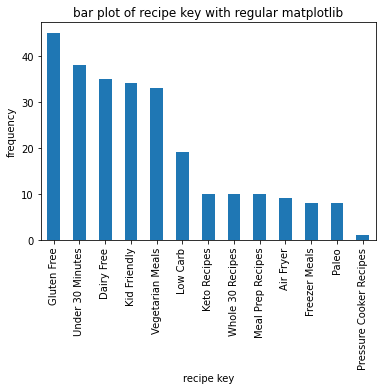

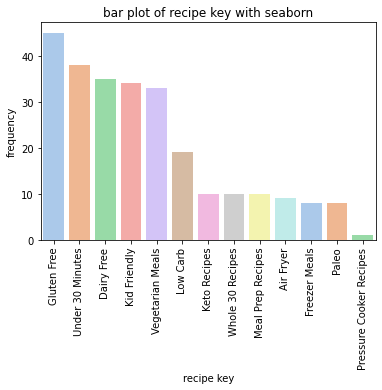

In [ ]:
"""
Task 3 (a)
Plot of Recipe key distribution
How? 
each recipe has multiple recipe keys  (list of list if you will)
we explode them into a single list and then plot the frequency bar plot.
Summary:
About 42/57 have Gluten free tag
Only about 2/57 have pressue cooker recipe 
"""
# regular matplotlib bar plot  
plt.figure()
recipe_keys_series.value_counts().plot.bar()
plt.title('bar plot of recipe key with regular matplotlib')
plt.xlabel('recipe key')
plt.ylabel('frequency')
plt.figure()

# seaborn is kinda stubborn so extra processing of data is done
rkvc = recipe_keys_series.value_counts().to_frame().reset_index()
rkvc.columns = ['recipe key', 'frequency']
sns.barplot(data=rkvc,
            x='recipe key',
            y='frequency',
            palette='pastel')
plt.xticks(rotation=90)
plt.title('bar plot of recipe key with seaborn')


Text(0, 0.5, 'frequency (normalised)')

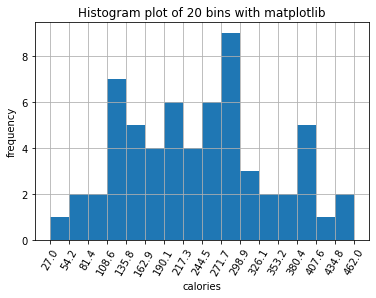

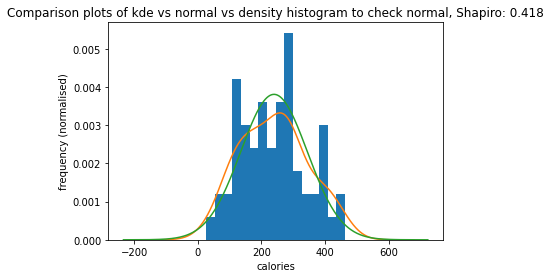

In [ ]:
"""
Task 3 b - calories Distribution 

divided into 16 bins we plot a histogram for calories since it's continuous 
values, you would prefer to understand its distribution by binning.

Then we check for if it belongs to normal distribution - shapiro says it is.
there's not enough evidence to reject it
"""
# regular matplotlib histogram plot  
_, ax = plt.subplots()
bins_edges = np.histogram_bin_edges(t3_df['cals'], bins=16)
t3_df['cals'].hist(bins=bins_edges, ax=ax, xrot=60)
ax.set_title('Histogram plot of 20 bins with matplotlib')
ax.set_xlabel('calories')
ax.set_ylabel('frequency')
ax.set_xticks(bins_edges)

# kde vs normal vs histogram density for clearer understanding
# shapiro test to see if it belongs to a normal distribution 
# (a normal distribution, not normal distribution one with mean and variance of the data)
normal_result = stats.shapiro(t3_df['cals'])
_, ax = plt.subplots()
t3_df['cals'].hist(bins=bins_edges, ax=ax, density=True, xrot=60)
t3_df['cals'].plot.density(ax=ax)
xlims = ax.get_xlim()
x = np.linspace(xlims[0], xlims[1], 400)
y = stats.norm(loc=t3_df['cals'].mean(), 
               scale=t3_df['cals'].std()).pdf(x)
ax.plot(x, y)
ax.set_title('Comparison plots of kde vs normal vs density histogram to check normal, Shapiro: {0:1.3g}'.format(normal_result[1]))
ax.set_xlabel('calories')
ax.set_ylabel('frequency (normalised)')



([<matplotlib.axis.XTick at 0x7f570e514450>,
 <a list of 12 Text major ticklabel objects>)

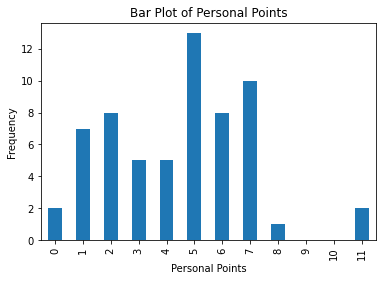

In [ ]:
"""
Task 3 c - personal points distribution 
Processing of personal points data:
we remove all + - and other string in the personal points so that it can
fit as an integer. We consider 6+ to be the same as 6

Bar Plot
For this case we take personal point as an ordinal variable 
We think it's because it's a subjective assignment like movie score. 
1+1 does not necessary equate to 2. 
whereas in calories, there's a clear unit.
therefore we shall plot a bar plot. 
"""
ppmin = t3_df['pp'].min()
ppmax = t3_df['pp'].max()
plt.figure()
bin_edges = [i for i in range(ppmin, ppmax+1)]
data_se = t3_df['pp'].value_counts(dropna=False)
index_not_in = [i for i in range(ppmin, ppmax+1) if i not in data_se.index]
data_se = data_se.append(pd.Series([0]*len(index_not_in), index=index_not_in))
data_se.sort_index().plot.bar()
plt.title('Bar Plot of Personal Points')
plt.xlabel('Personal Points')
plt.ylabel('Frequency')
plt.xticks(bin_edges)


Text(0.5, 1.0, 'Scatter plot of personal points vs calories, spearman: 0.562, p-val: 2.39e-06')

<Figure size 432x288 with 0 Axes>

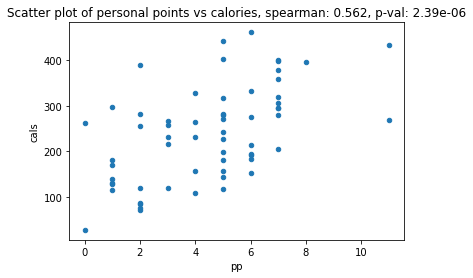

In [ ]:
"""
Task 3 c extra - correlation of ordinal pp vs continuous cals
i'm not sure if what i'm doing is right or not but i'm basically observing
if there's a correlation between personal points vs calories
since this is ordinal vs continuous, ill use spearman instead of pearson  
spearman is basically pearson but you rank items being compared
"""
"""
Summary:
potential outliers: pp at 11(or 0 too because how can u give 0 personal point) may ned to be checked
correlation strength: 0.559, p-val: 6.21e-06 very small basically
therefore, there is enough evidence to suggest a positive correlation between
personal points and calories.
(aka the author have personal preference for higher calories recipes)
"""
# therefore we have a scatter plot with the correlation value at the title
spearman_r = stats.spearmanr(t3_df[['pp', 'cals']].values)
plt.figure()
t3_df.plot.scatter(x='pp', y='cals')
plt.title('Scatter plot of personal points vs calories, spearman: {0:1.3g}, p-val: {1:1.3g}'.format(
    spearman_r.correlation,
    spearman_r.pvalue
))

In [ ]:
"""
Task 4 - implementation
idea: 
jupyter widget for user interaction with filtering calories and personal points
only top 5 calorie menus are selected, then sort the 5 in ascending order. 
path_to_html is used to convert image link into html tag
the entire dataframe is then returned as html for displaying image 
"""
import ipywidgets as widgets
t4_df = t3_df # change your df here
# initialize slider for task4 widget 
calorie_slider = widgets.IntRangeSlider(value=[0,t4_df['cals'].max()], min=0, max=t4_df['cals'].max())
points_slider = widgets.IntRangeSlider(value=[0,t4_df['pp'].max()], min=0, max=t4_df['pp'].max())

def path_to_image_html(path: str) -> str:
    return '<img src="'+ path + '" width="60" >'    

def task4_warpper(t4_df): # basically to inject t4_df before making wiget 
  @widgets.interact(cal_range=calorie_slider, points_range=points_slider)
  def task4(cal_range, points_range):
    # filters - cal, pp 
    cal_f = t4_df[(t4_df['cals'] <= cal_range[1]) & (t4_df['cals'] >= cal_range[0])]
    fil_df = cal_f[(cal_f['pp'] <= points_range[1]) & (cal_f['pp'] >= points_range[0])]
    # select top 5 calories
    results = fil_df.sort_values(by='cals', ascending=False)[:5][['name','img', 'summary', 'cals', 'pp']]
    # sort them for return by ascending order in term of calories
    # based on this https://moodle.abo.fi/mod/forum/discuss.php?d=202414
    results = results.sort_values(by='cals', ascending=True)
    return HTML(results.to_html(escape=False,formatters=dict(img=path_to_image_html)))
  return task4

# HTML(df.to_html(escape=False,formatters=dict(img=path_to_image_html)))
task4_warpper(t4_df)

interactive(children=(IntRangeSlider(value=(0, 462), description='cal_range', max=462), IntRangeSlider(value=(…

<function __main__.task4_warpper.<locals>.task4(cal_range, points_range)>